# Misc support functions
The class object in this script can easily pass all needed config and data to any object (instead of putting it one by one...)
- model_cfg: a header class to store every settings
- my_data: a data loader, obtain every data needed for modeling and analysis

In [1]:
# from google.colab import drive
# drive.mount('/content/drive')
# %cd 'drive/My Drive/Colab Notebooks/basicO2P'
%cd '/home/jupyter/tf/O2P'
!ls

/home/jupyter/tf/O2P
basicOP_master.ipynb   data_wrangling.py  models		 __pycache__
basicOSP_master.ipynb  input		  my_eval.py
custom_layer.py        misc.py		  pho_task_master.ipynb


In [2]:
%%writefile misc.py

class model_cfg():
    
    def __init__(self, code_name=None, sample_name='hs04', sample_rng_seed=329, 
                 o_input_dim=119, hidden_units=150, pho_units=250, cleanup_units=50, 
                 embed_attractor=None,
                 w_oh_noise=0., w_hp_noise=0., w_pp_noise=0., w_pc_noise=0., w_cp_noise=0.,
                 act_p_noise=0., 
                 tau=0.2, unit_time=4.,
                 n_mil_sample=1., batch_size=128, rnn_activation='sigmoid',
                 w_initializer='glorot_uniform', learning_rate=0.01, save_freq=5):
        
        self.code_name = code_name

        # Sampling
        self.sample_name = sample_name
        self.sample_rng_seed = sample_rng_seed

        # Architechture
        self.o_input_dim = o_input_dim
        self.hidden_units = hidden_units
        self.pho_units = pho_units
        self.cleanup_units = cleanup_units
        
        self.embed_attractor = embed_attractor

        self.w_oh_noise = w_oh_noise
        self.w_hp_noise = w_hp_noise
        self.w_pp_noise = w_pp_noise
        self.w_pc_noise = w_pc_noise
        self.w_cp_noise = w_cp_noise
        self.act_p_noise = act_p_noise

        ## This is for switching between testing and training mode
        self.w_oh_noise_backup = self.w_oh_noise   
        self.w_hp_noise_backup = self.w_hp_noise
        self.w_pp_noise_backup = self.w_pp_noise
        self.w_pc_noise_backup = self.w_pc_noise
        self.w_cp_noise_backup = self.w_cp_noise
        self.act_p_noise_backup = self.act_p_noise

        self.tau = tau
        self.unit_time = unit_time
        self.n_timesteps = int(self.unit_time * (1/self.tau))

        # Training
        self.n_mil_sample = n_mil_sample
        self.nEpo = int(n_mil_sample * 1e2)                 
        self.batch_size = batch_size
        self.steps_per_epoch = int(10000/batch_size)
        self.rnn_activation = rnn_activation
        self.w_initializer = w_initializer
        self.learning_rate = learning_rate

        # Saving
        self.save_freq = save_freq          
        self.eval_freq = self.save_freq

        self.gen_paths()
        self.gen_cfg_dict()
        self.write_cfg()

    def gen_cfg_dict(self):
        self.cfg_dict = {'code_name': self.code_name, 
                        'sample_name': self.sample_name,
                        'sample_rng_seed': self.sample_rng_seed,
                        'o_input_dim': self.o_input_dim,
                        'hidden_units': self.hidden_units,
                        'pho_units': self.pho_units,
                        'cleanup_units': self.cleanup_units, 
                        'embed_attractor': self.embed_attractor,
                        'w_oh_noise': self.w_oh_noise,
                        'w_hp_noise': self.w_hp_noise,
                        'w_pp_noise': self.w_pp_noise,
                        'w_pc_noise': self.w_pc_noise,
                        'w_cp_noise': self.w_cp_noise,
                        'act_p_noise': self.act_p_noise,
                        'tau': self.tau,
                        'unit_time': self.unit_time,
                        'n_timesteps': self.n_timesteps,
                        'n_mil_sample': self.n_mil_sample, 
                        'nEpo': self.nEpo, 
                        'batch_size': self.batch_size, 
                        'steps_per_epoch': self.steps_per_epoch, 
                        'rnn_activation': self.rnn_activation, 
                        'w_initializer': self.w_initializer, 
                        'learning_rate': self.learning_rate}

    def write_cfg(self):
        import json
        json = json.dumps(self.cfg_dict)
        f = open(self.path_model_folder + 'model_config.json',"w")
        f.write(json)
        f.close()
        
       
    def gen_paths(self):
        import os
    
        self.path_model_folder = 'models/'+ self.code_name + '/'
        self.path_log_folder = self.path_model_folder + 'log/'
        self.path_weight_folder = self.path_model_folder + 'weights/'
        self.path_plot_folder = self.path_model_folder + 'plots/'

        self.path_weights_checkpoint = self.path_weight_folder + 'ep{epoch:04d}.h5'
        self.path_history_pickle = self.path_model_folder + 'history.pickle'
        
        if self.embed_attractor is not None:
            self.path_attractor = 'models/'+ self.embed_attractor + '/model.h5'

        if not os.path.exists(self.path_model_folder): os.mkdir(self.path_model_folder) 
        if not os.path.exists(self.path_weight_folder): os.mkdir(self.path_weight_folder) 
        if not os.path.exists(self.path_log_folder): os.mkdir(self.path_log_folder) 
        if not os.path.exists(self.path_plot_folder): os.mkdir(self.path_plot_folder)  

        self.path_weights_list = []
        self.saved_epoch_list = []
        
        for epoch in range(self.save_freq, self.nEpo+1, self.save_freq):
            self.path_weights_list += [self.path_weight_folder + 'ep' + 
                                       str(epoch).zfill(4) + '.h5']
            
            self.saved_epoch_list.append(epoch)

        self.strain_item_csv = self.path_model_folder + 'result_strain_item.csv'
        self.strain_epoch_csv = self.path_model_folder + 'result_strain_epoch.csv'
        self.grain_item_csv = self.path_model_folder + 'result_grain_item.csv'
        self.grain_epoch_csv = self.path_model_folder + 'result_grain_epoch.csv'



    
            
def plot_variables(model):
    import matplotlib.pyplot as plt
    import numpy as np
    nv = len(model.trainable_variables)
    plt.figure(figsize=(20,20), facecolor='w')
    for i in range(nv):

        # Expand dimension for biases
        if model.trainable_variables[i].numpy().ndim == 1:
            plot_data = model.trainable_variables[i].numpy()[np.newaxis,:]
        else:
            plot_data = model.trainable_variables[i].numpy()

        plt.subplot(3, 3, i+1)
        plt.title(model.trainable_variables[i].name)
        plt.imshow(plot_data, cmap='jet', interpolation='nearest', aspect="auto")
        plt.colorbar()

        



class attractor():
    def __init__(self, cfg):
        from misc import plot_variables
        self.cfg = cfg
        self.model = self.build_model()
        self.model.load_weights(cfg.path_attractor)
        
        rnn_layer = self.model.get_layer('rnn')
        names = [weight.name for weight in rnn_layer.weights]
        weights = self.model.get_weights()

        for name, weight in zip(names, weights):
            print(name, weight.shape)
            if name.endswith('w_pp:0'): self.pretrained_w_pp = weight
            if name.endswith('w_pc:0'): self.pretrained_w_pc = weight
            if name.endswith('w_cp:0'): self.pretrained_w_cp = weight
            if name.endswith('bias_p:0'): self.pretrained_bias_p = weight
            if name.endswith('bias_c:0'): self.pretrained_bias_c = weight
        
        plot_variables(self.model)
    
def build_model(self):
        from tensorflow.keras import Model
        from tensorflow.keras.layers import Layer, Input
        from custom_layer import rnn_pho_task
        from tensorflow.keras.optimizers import Adam

        input_p = Input(shape=(self.cfg.pho_units,), name='pho_task_input')
        rnn_model = rnn_pho_task(self.cfg, name='rnn')(input_p)
        model = Model(input_p, rnn_model)

#         adam = Adam(learning_rate=self.cfg.learning_rate, 
#                     beta_1=0.9, beta_2=0.999, amsgrad=False)

#         model.compile(loss='binary_crossentropy',
#                     optimizer=adam,
#                     metrics=['BinaryAccuracy', 'mse'])

#         model.summary()
        
        return model

    
    




Overwriting misc.py


In [ ]:
class attractor():
    def __init__(self, cfg):
        from misc import plot_variables
        self.cfg = cfg
        self.model = self.build_model()
        self.model.load_weights(cfg.path_attractor)
        
        rnn_layer = self.model.get_layer('rnn')
        names = [weight.name for weight in rnn_layer.weights]
        weights = self.model.get_weights()

        for name, weight in zip(names, weights):
            print(name, weight.shape)
            if name.endswith('w_pp:0'): self.pretrained_w_pp = weight
            if name.endswith('w_pc:0'): self.pretrained_w_pc = weight
            if name.endswith('w_cp:0'): self.pretrained_w_cp = weight
            if name.endswith('bias_p:0'): self.pretrained_bias_p = weight
            if name.endswith('bias_c:0'): self.pretrained_bias_c = weight
        
        plot_variables(self.model)
    
    def build_model(self):
        from tensorflow.keras import Model
        from tensorflow.keras.layers import Layer, Input
        from custom_layer import rnn_pho_task
        from tensorflow.keras.optimizers import Adam

        input_p = Input(shape=(self.cfg.pho_units,), name='pho_task_input')
        rnn_model = rnn_pho_task(self.cfg, name='rnn')(input_p)
        model = Model(input_p, rnn_model)

#         adam = Adam(learning_rate=self.cfg.learning_rate, 
#                     beta_1=0.9, beta_2=0.999, amsgrad=False)

#         model.compile(loss='binary_crossentropy',
#                     optimizer=adam,
#                     metrics=['BinaryAccuracy', 'mse'])

#         model.summary()
        
        return model
cfg = model_cfg(code_name='RNN_v0.60', 
                sample_name='hs04', 
                sample_rng_seed=303,
                hidden_units=150, 
                pho_units=250, 
                cleanup_units=50,
                embed_attractor='p_task_v0.02',
                w_oh_noise=0.,
                w_hp_noise=0.,
                w_pp_noise=4.,
                w_pc_noise=4.,
                w_cp_noise=4.,
                act_p_noise=0.,
                tau=0.2, 
                unit_time=4., 
                n_mil_sample=1., 
                batch_size=128, 
                rnn_activation = 'sigmoid',
                w_initializer = 'glorot_uniform',
                learning_rate=0.01,
                save_freq=5)
attractor(cfg)

In [ ]:
def arm_attractor(model, cfg):
    from misc import attractor
    attractor = attractor(cfg)
    



names = [weight.name for weight in model.get_layer('rnn').weights] 
weights = model.get_weights()

n_matrices = len(model.get_layer('rnn').weights)
new_weights = []
for i in range(n_matrices):
    # Align model and attractor weight matrices
    
    # Get attractor value if weight matrix name match attractor 
    if model.get_layer('rnn').weights[i].name.endswith('w_pp:0'):
        new_weights.append(attractor.pretrained_w_pp)

    if model.get_layer('rnn').weights[i].name.endswith('w_pc:0'): 
        new_weights.append(attractor.pretrained_w_pc)
        
    if model.get_layer('rnn').weights[i].name.endswith('w_cp:0'): 
        new_weights.append(attractor.pretrained_w_cp)
        
    if model.get_layer('rnn').weights[i].name.endswith('bias_p:0'): 
        new_weights.append(attractor.pretrained_bias_p)
        
    if model.get_layer('rnn').weights[i].name.endswith('bias_c:0'): 
        new_weights.append(attractor.pretrained_bias_c)
    
    # Fill original value if this slot have not been filled
    if len(new_weights) < i + 1:
        new_weights.append(model.get_weights()[i])

# new_weights

model.set_weights(new_weights)

Minimal install script for new DLVM

In [ ]:
!sudo pip install altair
!sudo pip install pandas-gbq -U
!sudo pip install yapf

## Checking

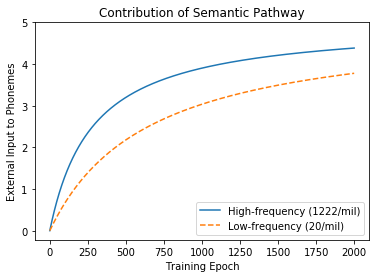

In [55]:
def semantic_influence_np(t, f, g=5, k=2000):
    import numpy as np
    # Based on Plaut et al. 96 sims 4
    # This function is for checking semantic_influence()
    # S = g (log(f+2)*t) / (log(g+2)*t + k)
    # Where g and k is scaling factors
    # t is epoch
    # f is word frequency
    lt = np.log(f+2)*t
    return g*lt/(lt+k)

# Sanity check Plaut96 fig.21
t= range(2000)
s_high = [semantic_influence_np(x, 1222) for x in t]
s_low = [semantic_influence_np(x, 20) for x in t]

import matplotlib.pyplot as plt

fig, ax = plt.subplots()
line1, = ax.plot(t, s_high, label='High-frequency (1222/mil)')
line2, = ax.plot(t, s_low, label='Low-frequency (20/mil)', linestyle='dashed')
ax.legend(loc='lower right')
ax.set_title('Contribution of Semantic Pathway')
ax.set_xlabel('Training Epoch')
ax.set_ylabel('External Input to Phonemes')
plt.ylim(top=5)
plt.show()

### Code formatter

In [31]:
import os
from yapf.yapflib.yapf_api import FormatFile

for file in os.listdir():
    if file.endswith('.py'):
        FormatFile(file, in_place=True)